# Question 4

## 2. The West Coast Heat Wave

In 2016 [Dr. Chelle Gentemann](https://cgentemann.github.io) and collaborators published a [paper](https://agupubs.onlinelibrary.wiley.com/doi/10.1002/2016GL071039) on the heat wave in the ocean off the California coast

The analysis was then performed using Matlab to process scientific data. To make Figure 1, here are the following steps:
- Download 4 TB of data from NASA PO.DAAC data archive via FTP
- Go through each day of data and subset to the West Coast Region to reduce size and save each subsetted day
- Go through 2002-2012 and create a daily climatology and save all 365 days of the climatology
- Go through each day of data and calculate the anomaly and save each day's anomaly

This whole process took about 1-2 month. 
Below we will do this using MUR SST data on AWS Open Data Program in a few minutes using Python.

In [6]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec
import matplotlib.pyplot as plt

import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

Subset all the data to just the West Coast region

In [7]:
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")
ds

<xarray.Dataset>
Dimensions:           (time: 6443, lat: 251, lon: 234)
Coordinates:
  * lat               (lat) float32 33.0 33.06 33.12 33.18 ... 47.88 47.94 48.0
  * lon               (lon) float32 -132.0 -131.9 -131.9 ... -118.1 -118.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-2...
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

This is how a rough version of one of the plots in the paper look like

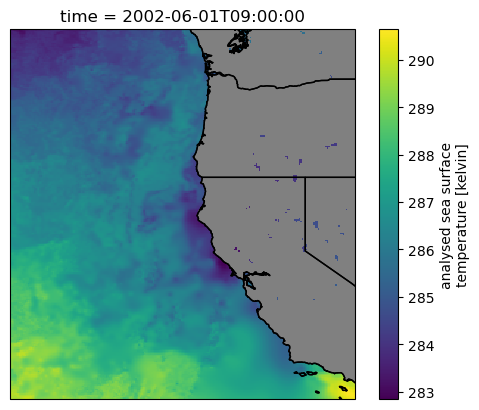

In [8]:
ds.analysed_sst[0, :, :].plot()

# Plot on a map
ax = plt.subplot(projection=crs)
ds.analysed_sst[0, :, :].plot(ax=ax, transform=crs)
ax.coastlines("10m", color="k")
ax.add_feature(cfeature.LAND, color="grey")
ax.add_feature(cfeature.STATES.with_scale("10m"))

### Question 4 [10 points]

Reproduce Figure 1 in the paper. When doing that, try to slice data using `xarray` in the most clear and reproducible way (for example, don't use indices to access data objects like we did in the example above).

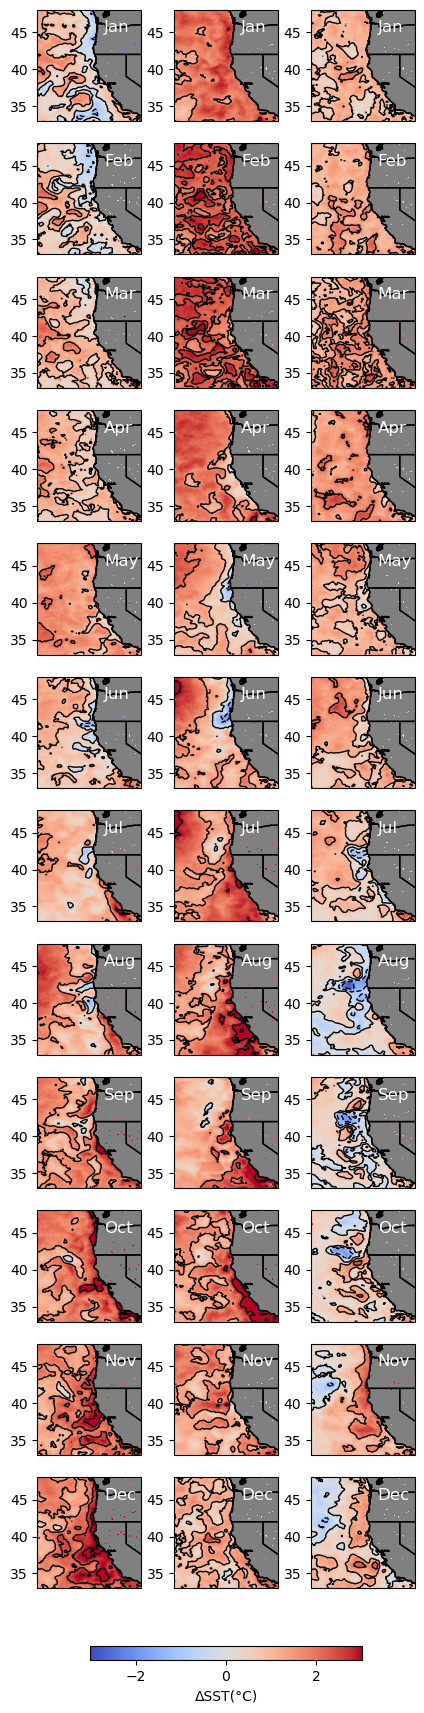

In [9]:
# calculate monthly mean for further operations
sst = ds['analysed_sst']
year_range = sst.sel(time=slice('2002', '2012'))
monthly_avg = year_range.groupby(year_range.time.dt.month).mean()
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# set the figure for plot
fig, axs = plt.subplots(figsize=(5,25), nrows=12, ncols=3, subplot_kw=dict(projection=crs))

# create subplots for every month from 2014 to 2016
for y in range(2014, 2017):
    for m in range(1, 13):
        # prepare anomaly data for subplots
        sample = sst.sel(time = (sst.time.dt.year==y) & (sst.time.dt.month==m)).mean(dim='time')
        avg = monthly_avg.sel(month = m)
        anomaly = sample-avg
        
        # plot subplots
        cmap = anomaly.plot(ax=axs[m-1, y-2014], transform=crs, add_colorbar=False,cmap='coolwarm', vmin=-3, vmax=3) 
        anomaly.plot.contour(ax=axs[m-1, y-2014], colors='black', linewidths=1, cmin=-3, cmax=3)
        
        # modify ticks and labels for subplots
        axs[m-1, y-2014].set_yticks(range(35,46,5))
        axs[m-1, y-2014].set_ylabel('')
        axs[m-1, y-2014].set_title('')
        axs[m-1, y-2014].text(-123, 45, month[m-1], fontsize=12, color = 'white')
        axs[m-1, y-2014].coastlines("10m", color="k")
        axs[m-1, y-2014].add_feature(cfeature.LAND, color="grey")
        axs[m-1, y-2014].add_feature(cfeature.STATES.with_scale("10m"))
        
# create a colorbar
cbar = plt.colorbar(cmap, ax=axs, location='bottom', shrink=0.7, pad=0.03)
cbar.set_label('ΔSST(°C)')
cbar.set_ticks(range(-2,3,2))

plt.show()